In [321]:
from itertools import chain, combinations

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st

np.set_printoptions(suppress = True)

data = pd.read_csv('carmpg.csv')
data

,MODEL,VOL,HP,MPG,SP,WT
0,GM/GeoMetroXF1,89,49,65.4,96,17.5
1,GM/GeoMetro,92,55,56.0,97,20.0
2,GM/GeoMetroLSI,92,55,55.9,97,20.0
3,SuzukiSwift,92,70,49.0,105,20.0
4,DaihatsuCharade,92,53,46.5,96,20.0
...,...,...,...,...,...,...
77,Mercedes500SL,50,322,18.1,165,45.0
78,Mercedes560SEL,115,238,17.2,140,45.0
79,JaguarXJSConvert,50,263,17.0,147,45.0
80,BMW750IL,119,295,16.7,157,45.0


In [322]:
def powerset(s: list):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def regression(X: np.ndarray, Y: np.ndarray, feature_set: list[str] = None):
    # Num of samples
    n = X.shape[0]

    # Insert (1, X)
    X1 = np.insert(X, 0, 1, axis=1)

    # Num of features
    k = X1.shape[1]

    X_inv = np.linalg.inv(X1.T @ X1)

    # Fitted beta
    beta_hat: np.ndarray = X_inv @ X1.T @ Y

    # Residuals
    epsilon_hat: np.ndarray = Y - X1 @ beta_hat
    # Residuals error
    train_err = (epsilon_hat.T @ epsilon_hat).squeeze()
    sigma2_hat = 1/(n-k) * train_err

    se_hat = np.sqrt(np.diag( sigma2_hat * X_inv ))[:, None]

    # t-statistics
    t_scores = beta_hat / se_hat
    p_values = 2 * (1 - st.t.cdf(np.abs(t_scores), n-1))

    fit_results = np.concatenate((beta_hat, se_hat, t_scores, p_values), axis=1)
    index = ['const']+list(feature_set) if feature_set is not None else None
    fit_df = pd.DataFrame(
        fit_results, 
        index=index, 
        columns=['beta_hat', 'se_hat', 't_scores', 'p_values']
    )

    return fit_df, train_err, sigma2_hat

def get_mallow_score(S: tuple[str] | list[str], data: pd.DataFrame, Y: np.ndarray):
    X = data[list(S)].to_numpy()
    _, train_err, sigma2_hat = regression(X, Y)

    # Increase length due to constant variate
    return train_err + 2 * (len(S)+1) * sigma2_hat

def get_bic_score(S: tuple[str] | list[str], data: pd.DataFrame, Y: np.ndarray):
    X = data[list(S)].to_numpy()
    _, train_err, _ = regression(X, Y)

    n = X.shape[0]

    return n * np.log(train_err) + len(S)*np.log(n)

        beta_hat    se_hat   t_scores  p_values
const  50.066078  1.569487  31.899650       0.0
HP     -0.139023  0.012069 -11.519295       0.0


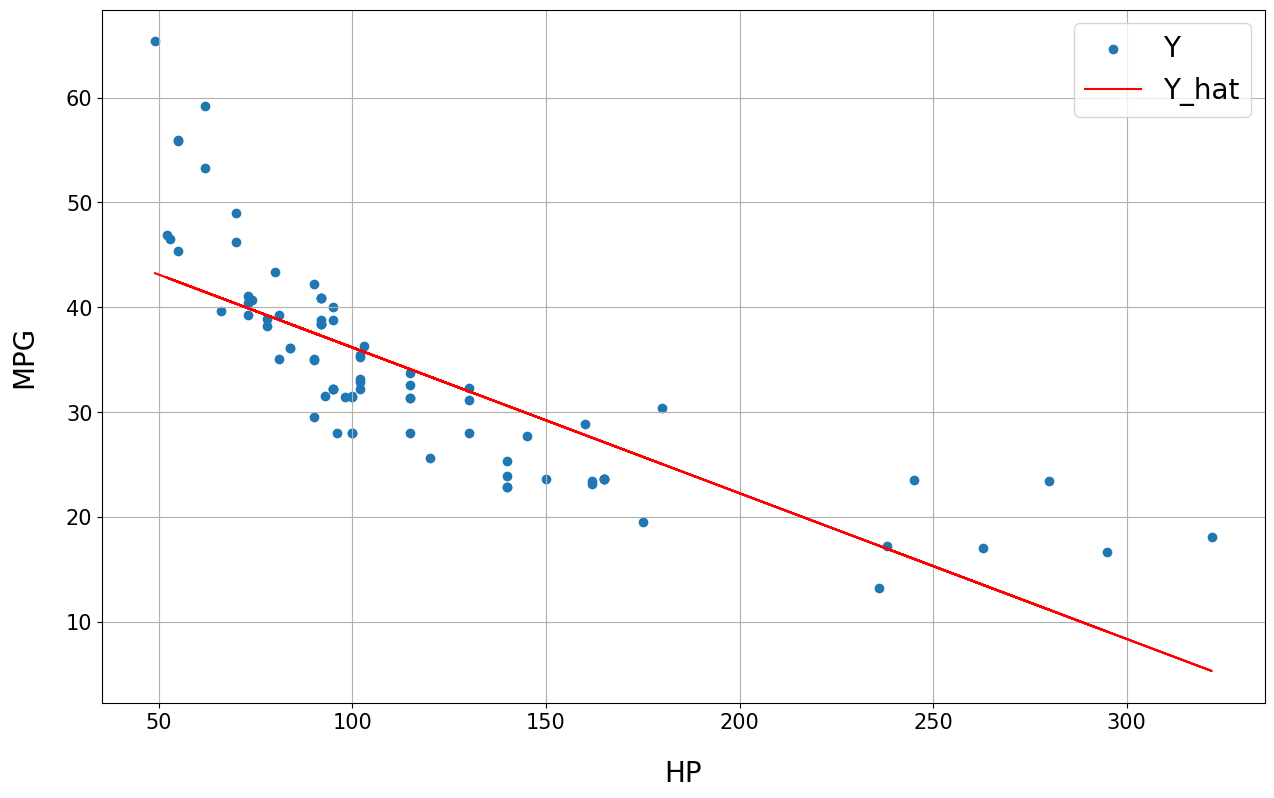

In [323]:
Y = data['MPG'].to_numpy()[:, None]
X_features = ['HP', 'VOL', 'SP', 'WT']

# Model fit
X_HP = data['HP'].to_numpy()[:, None]
fit_df, _, _ = regression(X_HP, Y, ['HP'])
print(fit_df)

# Predictions
X1_HP = np.insert(X_HP, 0, 1, axis=1)
Y_hat = X1_HP @ fit_df['beta_hat'].to_numpy()

#  Plot
font_size = 20
label_pad = 20

plt.figure(figsize=(15, 9))
plt.grid()

plt.scatter(X_HP.squeeze(), Y.squeeze())
plt.plot(X_HP.squeeze(), Y_hat, color='r')

plt.legend(['Y', 'Y_hat'], fontsize=font_size)

plt.xlabel('HP', fontsize=font_size, labelpad=label_pad)
plt.ylabel('MPG', fontsize=font_size, labelpad=label_pad)

plt.xticks(fontsize=0.75*font_size)
plt.yticks(fontsize=0.75*font_size)

plt.show()

In [325]:
bic_results = []
for S in powerset(X_features):
    if not S:
        continue

    bic = get_bic_score(S, data, Y)
    bic_results.append((S, bic))

bic_df = pd.DataFrame(bic_results, columns=['S', 'Score'])
bic_df

,S,Score
0,"(HP,)",662.269074
1,"(VOL,)",730.475815
2,"(SP,)",689.776299
3,"(WT,)",602.210827
4,"(HP, VOL)",642.643354
5,"(HP, SP)",645.538729
6,"(HP, WT)",604.614324
7,"(VOL, SP)",664.691906
8,"(VOL, WT)",606.400081
9,"(SP, WT)",601.839520


In [326]:
print(mallow_df.loc[mallow_df['Score'] == mallow_df['Score'].min(), :])
print(bic_df.loc[bic_df['Score'] == bic_df['Score'].min(), :])

               S        Score
12  (HP, SP, WT)  1139.665317
               S       Score
12  (HP, SP, WT)  582.369976


In [329]:
fit_df, _, _ = regression(data[X_features], Y, X_features)
print(fit_df)

         beta_hat     se_hat  t_scores      p_values
const  192.437753  23.531613  8.177839  3.351097e-12
HP       0.392212   0.081412  4.817602  6.671547e-06
VOL     -0.015645   0.022825 -0.685425  4.950327e-01
SP      -1.294818   0.244773 -5.289864  1.019119e-06
WT      -1.859804   0.213363 -8.716617  2.888800e-13


In [331]:
import statsmodels.api as sm

model_sm = sm.OLS(data['MPG'], sm.add_constant(data[X_features])).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     132.7
Date:                Sun, 24 Sep 2023   Prob (F-statistic):           9.98e-34
Time:                        15:14:36   Log-Likelihood:                -220.00
No. Observations:                  82   AIC:                             450.0
Df Residuals:                      77   BIC:                             462.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        192.4378     23.532      8.178      0.000     145.580     239.295
HP             0.3922      0.081      4.818      0.000       0.230       0.554
VOL           -0.0156      0.023     -0.685      0.495      -0.061       0.030
SP            -1.2948      0.245     -5.290      0.000      -1.782      -0.807
WT            -1.8598      0.213     -8.717      0.000      -2.285      -1.435
==============================================================================
Omnibus:                       14.205   Durbin-Watson:                   1.148
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.605
Skew:                           0.784   Prob(JB):                     9.12e-05
Kurtosis:                       4.729   Cond. No.                     1.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [332]:
%reset -f

: 